Lorenzo Colletta, Giorgio Fantilli, Luca Lucioli

## Parte 1 - Descrizione del problema

Il dataset in esame include dati per la stima dei livelli di obesità negli individui provenienti dai paesi di Messico, Perù e Colombia, in base alle loro abitudini alimentari e alle condizioni fisiche. `TODO`

Di seguito vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [102]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Caricamento dati e preprocessing

In [103]:
file_zip_url = "https://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip"
file_zip_name = "obesity_data.zip"
file = "./ObesityDataSet_raw_and_data_sinthetic.csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

obesity_row_data = pd.read_csv(file)
obesity_row_data = obesity_row_data.rename(columns={"family_history_with_overweight" : "FHWO", "NObeyesdad" : "ObesityLevel"})

obesity_row_data.head(10)

,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,ObesityLevel
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


Sopra viene mostrato un piccolo estratto del dataset in esame, dopo aver rinominato alcune feature per migliorarne la leggibilità e l'utilizzo.

Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset.


In [104]:
obesity_row_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        2111 non-null   object 
 1   Age           2111 non-null   float64
 2   Height        2111 non-null   float64
 3   Weight        2111 non-null   float64
 4   FHWO          2111 non-null   object 
 5   FAVC          2111 non-null   object 
 6   FCVC          2111 non-null   float64
 7   NCP           2111 non-null   float64
 8   CAEC          2111 non-null   object 
 9   SMOKE         2111 non-null   object 
 10  CH2O          2111 non-null   float64
 11  SCC           2111 non-null   object 
 12  FAF           2111 non-null   float64
 13  TUE           2111 non-null   float64
 14  CALC          2111 non-null   object 
 15  MTRANS        2111 non-null   object 
 16  ObesityLevel  2111 non-null   object 
dtypes: float64(8), object(9)
memory usage: 1.1 MB


Osserviamo come molte delle feature sono di tipo `object`. Procediamo di seguito con la trasformazione in variabili categoriche e booleane per limitare la memoria occupata.

In [105]:
categorical = ["Gender", "CAEC", "CALC", "MTRANS", "ObesityLevel"]
boolean = ["FHWO", "FAVC", "SMOKE", "SCC"]

obesity_row_data[categorical] = obesity_row_data[categorical].astype("category")

obesity_row_data[boolean] = obesity_row_data[boolean].replace({"yes": True, "no": False})

obesity_row_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Gender        2111 non-null   category
 1   Age           2111 non-null   float64 
 2   Height        2111 non-null   float64 
 3   Weight        2111 non-null   float64 
 4   FHWO          2111 non-null   bool    
 5   FAVC          2111 non-null   bool    
 6   FCVC          2111 non-null   float64 
 7   NCP           2111 non-null   float64 
 8   CAEC          2111 non-null   category
 9   SMOKE         2111 non-null   bool    
 10  CH2O          2111 non-null   float64 
 11  SCC           2111 non-null   bool    
 12  FAF           2111 non-null   float64 
 13  TUE           2111 non-null   float64 
 14  CALC          2111 non-null   category
 15  MTRANS        2111 non-null   category
 16  ObesityLevel  2111 non-null   category
dtypes: bool(4), category(5), float64(8)
memory usage: 15

Osserviamo come tutte le feature sono rileventi per il problema, e soprattutto che nessuna delle stesse presenta valori nulli. Non risulta perciò necessaria nessuna pulizia dei dati.

### Descrizione delle feature
Il dataset contiene le seguenti feature:
*   `Gender`: genere (Male, Female)
*   `Age`: età
*   `Height`: altezza in metri
*   `Weight`: peso in kilogrammi
*   `FHWO`: indica se il soggetto ha familiari che sono o sono stati sovrappeso (yes, no)
*   `FAVC`: indica se il soggetto mangia spesso cibo ad alto contenuto calorico o meno (yes, no)
*   `FCVC`: indica se solitamente il soggetto mangia verdura durante i pasti o meno (Never = 1, Sometimes = 2, Always = 3)
*   `NCP`: indica quanti pasti consuma il soggetto durante la giornata
*   `CAEC`: indica se il soggetto mangia tra i pasti (No, Sometimes, Frequently, Always)
*   `SMOKE`: indica se il soggetto fuma o meno (yes, no)
*   `CH2O`: indica quanta acqua beve il soggetto durante il giorno
*   `SCC`: indica se il soggetto monitora le calorie che assume durante il giorno (yes, no)
*   `FAF`: indica quanto spesso il soggetto svolge attività fisica durante la settimana
*   `TUE`: indica quanto spesso il soggetto utilizza apparecchi tecnologici durante il giorno come telefono, videogiochi, tv, computer o altri
*   `CALC`: indica quanto spesso il soggetto beve (Never, Sometimes, Frequently, Always)
*   `MTRANS`: indica quale mezzo di trasporto utilizza solitamente il soggetto (Automobile, Motorbike, Bike, Public Transport, Walking)

La variabile target è `ObesityLevel`, che rappresenta il livello di obesità nelle seguenti classi: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III.

Le features in esame sono sia categoriche, binarie, che continue:<br>
Tra le categoriche troviamo: `Gender`, `CAEC`, `CALC` e `MTRANS`.<br>
Tra le continue troviamo: `Age`, `Height`, `Weight`, `FCVC`, `NCP`, `CH2O`, `FAF` e `TUE`.<br>
Tra le binarie troviamo: `FHWO`, `FAVC`, `SMOKE` e `SCC`.

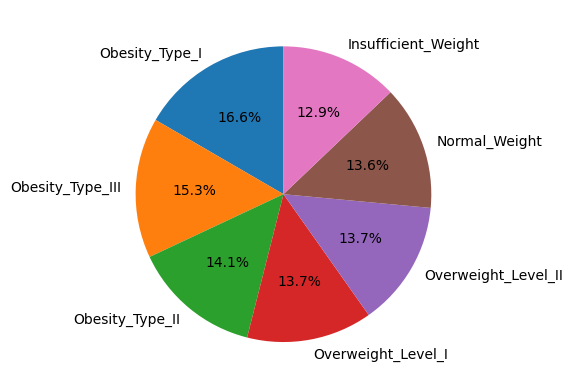

<Figure size 640x480 with 0 Axes>

<Axes: title={'center': 'Distribuzione delle Istanze per Livello di Obesità'}, xlabel='Livello di Obesità', ylabel='Numero di Istanze'>

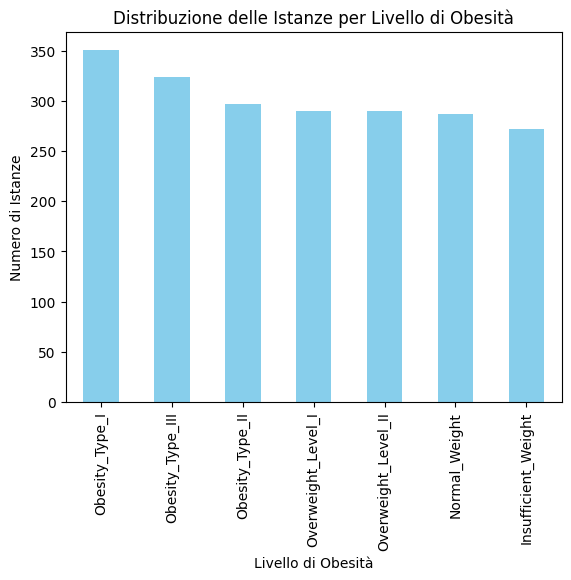

In [106]:
obesity_row_data["ObesityLevel"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel(None)
plt.figure().set_facecolor('white')
plt.show()

obesity_row_data["ObesityLevel"].value_counts().plot.bar(color='skyblue', rot=90, xlabel='Livello di Obesità', ylabel='Numero di Istanze', title='Distribuzione delle Istanze per Livello di Obesità')

Osserviamo dai grafici come la variabile target `ObesityLevel` risulta essere bilanciata, ovvero il numero di istanze per le possibili classi sono pressochè identiche.  Il problema in esame risulta quindi essere bilanciato e non e' necessario utilizzare tecniche di bilanciamento delle classi.

In [107]:
obesity_row_data.isna().sum()

Gender          0
Age             0
Height          0
Weight          0
FHWO            0
FAVC            0
FCVC            0
NCP             0
CAEC            0
SMOKE           0
CH2O            0
SCC             0
FAF             0
TUE             0
CALC            0
MTRANS          0
ObesityLevel    0
dtype: int64

Si verifica come nessuna delle feature del dataset presenta valori nulli. Osserviamo inoltre che tutte le variabili sono rileventi per la modellazione del problema. Non risulta perciò necessaria nessuna pulizia dei dati.

## Parte 2 - Analisi Esplorativa

In [108]:
obesity_row_data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


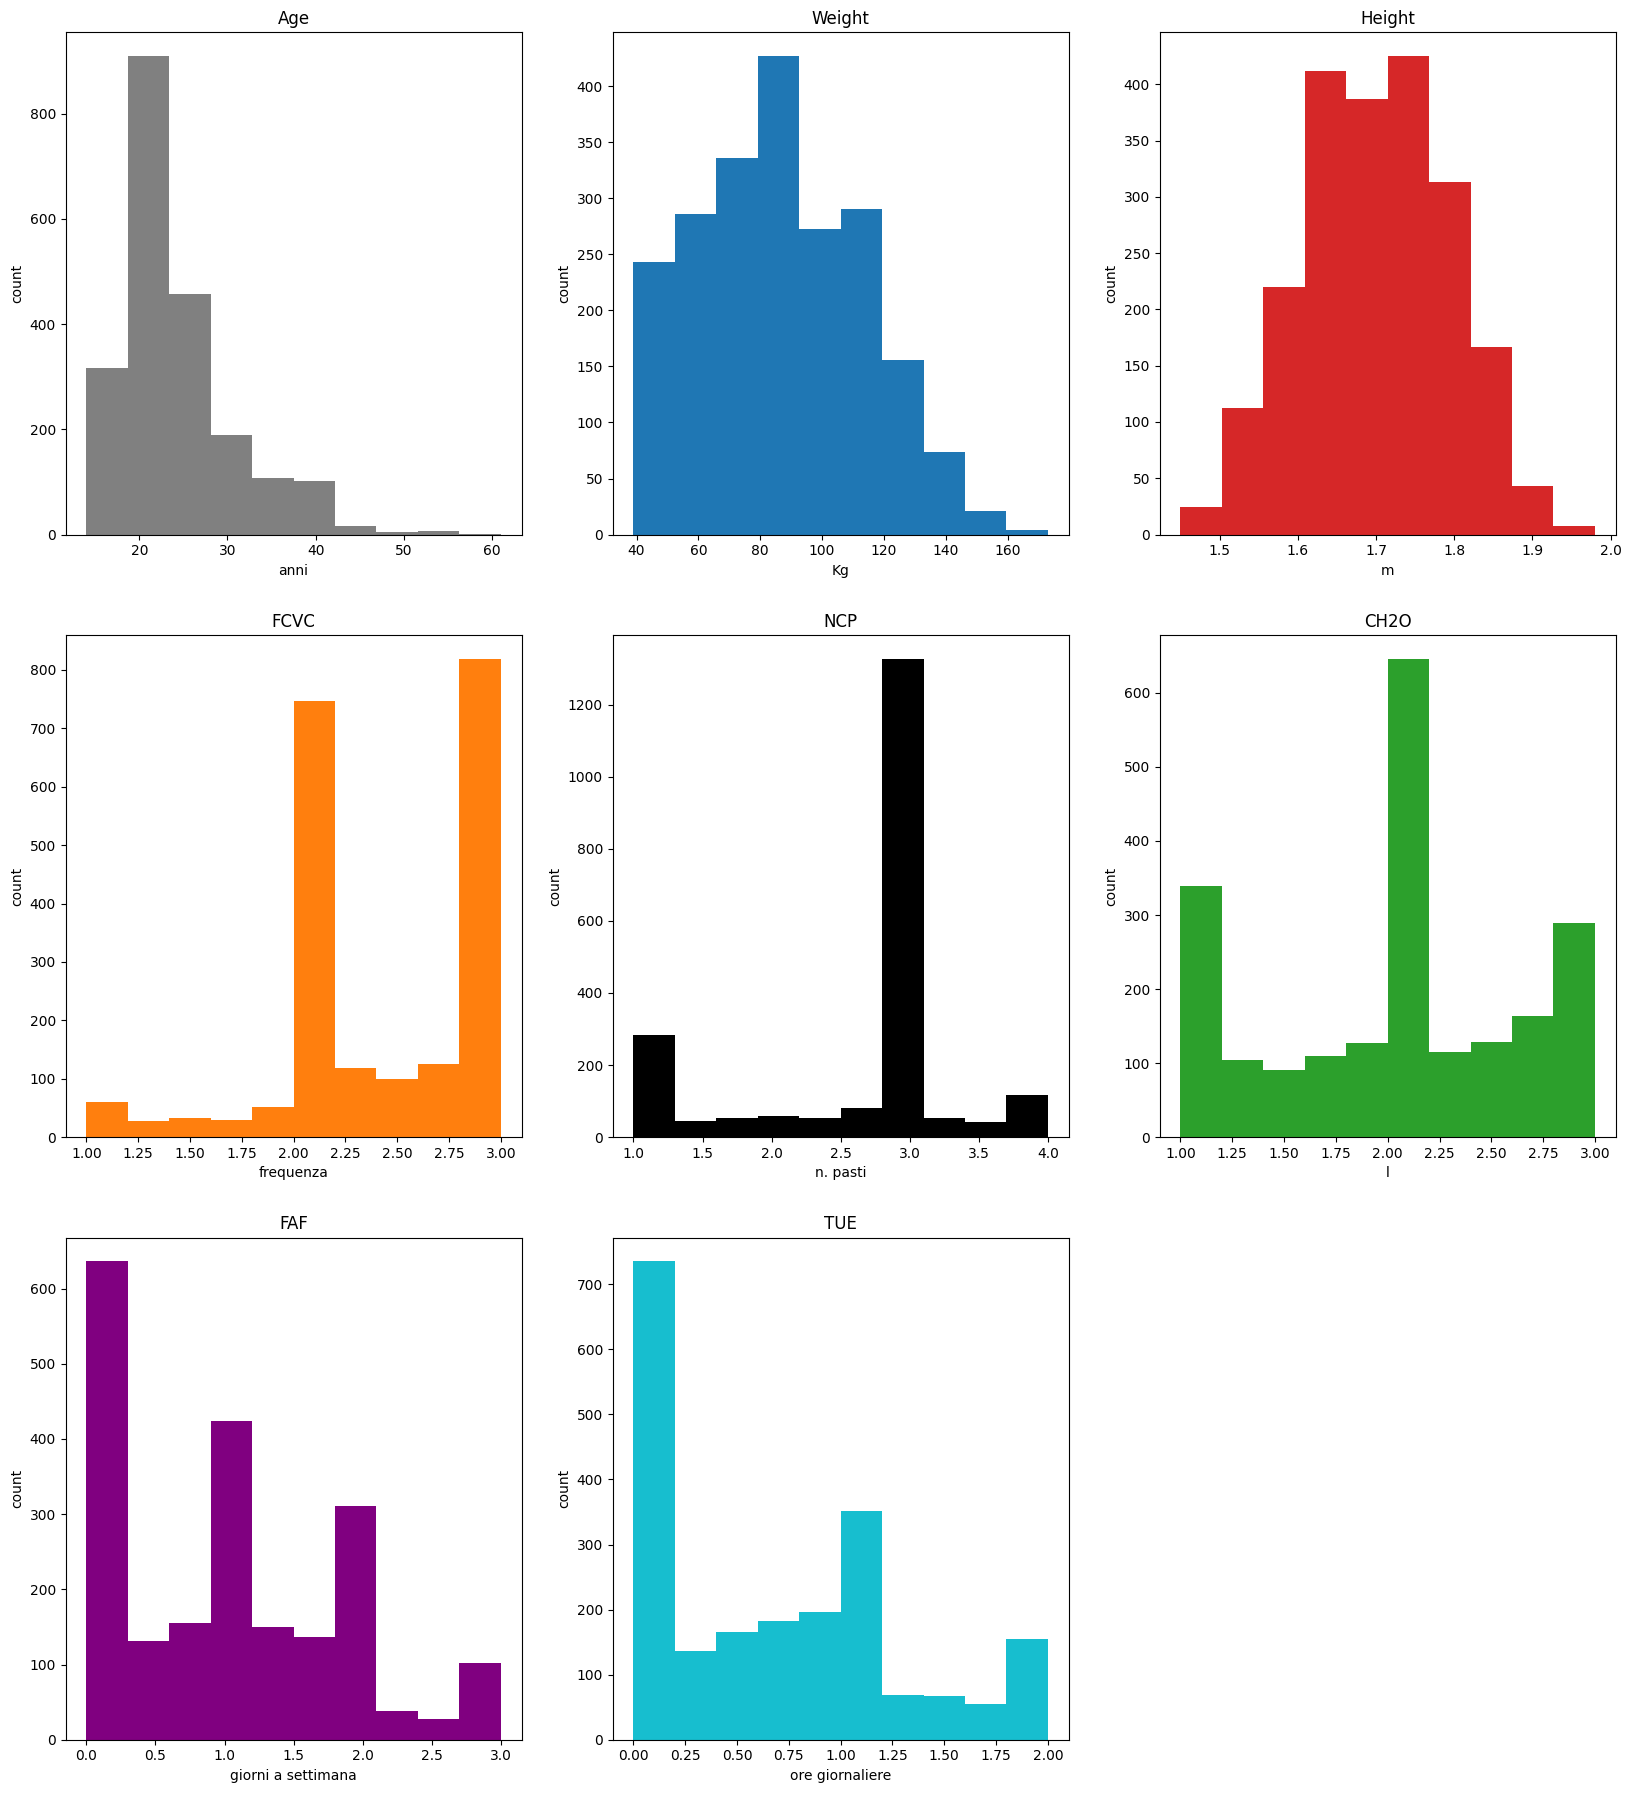

In [119]:
plt.figure(figsize=(20, 30))

plt.subplot(4, 3, 1)
plt.title('Age')
plt.hist(obesity_row_data['Age'], label="Age", color='gray')
plt.ylabel('count')
plt.xlabel('anni')

plt.subplot(4, 3, 2)
plt.title('Weight')
plt.hist(obesity_row_data['Weight'], label="weight")
plt.ylabel('count')
plt.xlabel('Kg')

plt.subplot(4, 3, 3)
plt.title('Height')
plt.hist(obesity_row_data['Height'], label="height", color="tab:red")
plt.ylabel('count')
plt.xlabel('m')

plt.subplot(4, 3, 4)
plt.title('FCVC')
plt.hist(obesity_row_data['FCVC'], label="FCVC", color="tab:orange")
plt.ylabel('count')
plt.xlabel('frequenza')

plt.subplot(4, 3, 5)
plt.title('NCP')
plt.hist(obesity_row_data['NCP'], label="NCP", color="black")
plt.ylabel('count')
plt.xlabel('n. pasti')

plt.subplot(4, 3, 6)
plt.title('CH2O')
plt.hist(obesity_row_data['CH2O'], label="CH2O", color="tab:green")
plt.ylabel('count')
plt.xlabel('l')

plt.subplot(4, 3, 7)
plt.title('FAF')
plt.hist(obesity_row_data['FAF'], label="FAF", color="purple")
plt.ylabel('count')
plt.xlabel('giorni a settimana')

plt.subplot(4, 3, 8)
plt.title('TUE')
plt.hist(obesity_row_data['TUE'], label="TUE", color="tab:cyan")
plt.ylabel('count')
plt.xlabel('ore giornaliere')

plt.show()

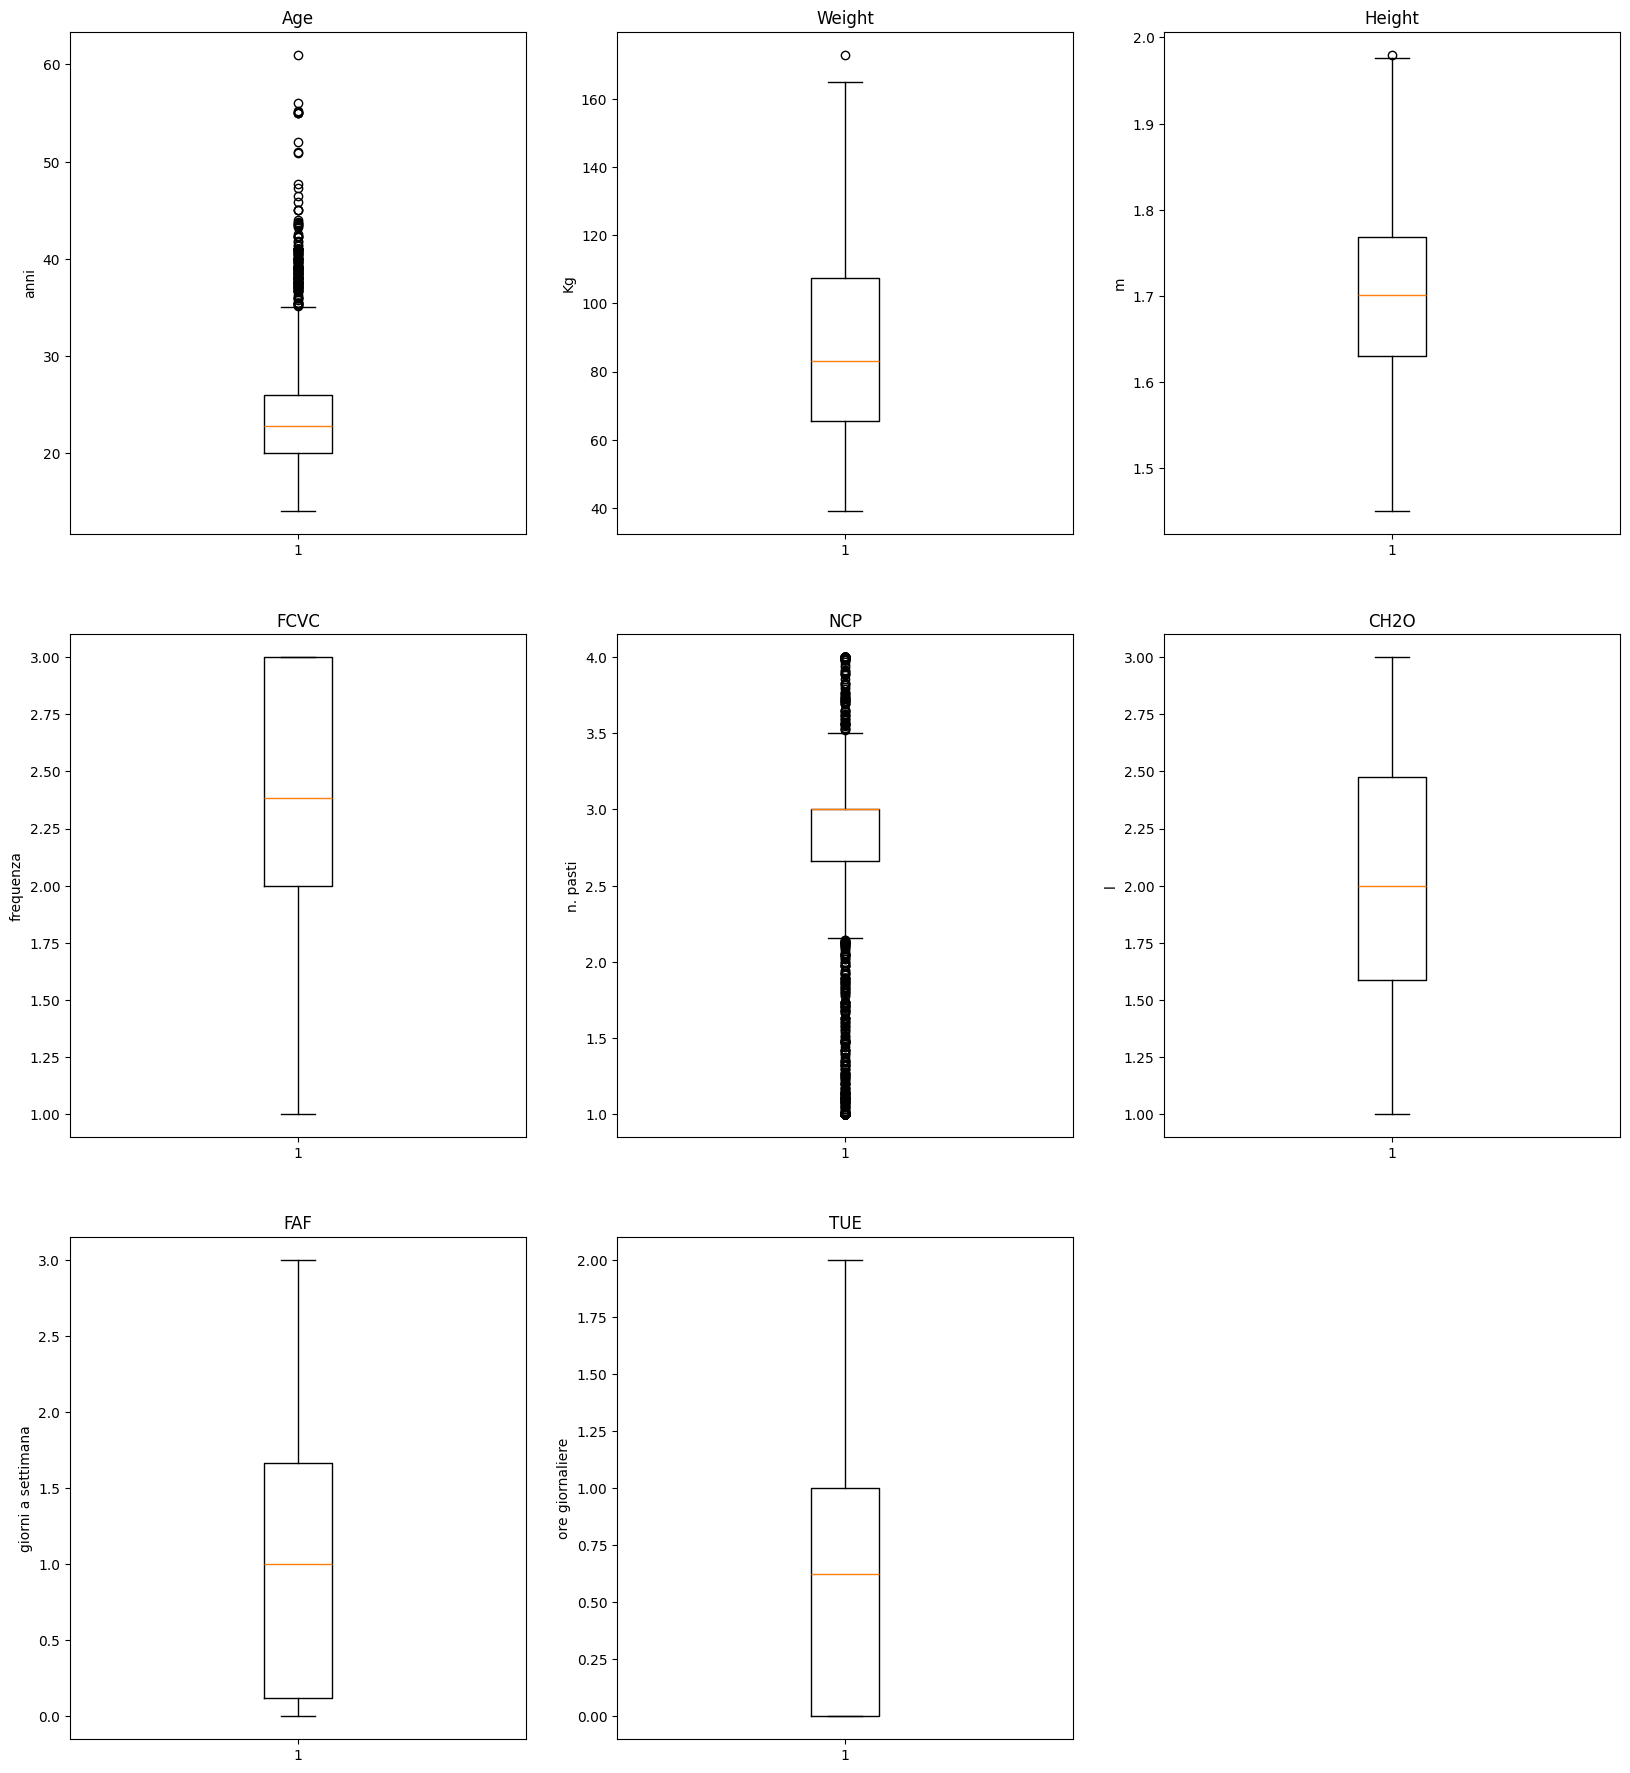

In [110]:
plt.figure(figsize=(20, 30))

plt.subplot(4, 3, 1)
plt.title('Age')
plt.boxplot(obesity_row_data['Age'])
plt.ylabel('anni')

plt.subplot(4, 3, 2)
plt.title('Weight')
plt.boxplot(obesity_row_data['Weight'])
plt.ylabel('Kg')

plt.subplot(4, 3, 3)
plt.title('Height')
plt.boxplot(obesity_row_data['Height'])
plt.ylabel('m')

plt.subplot(4, 3, 4)
plt.title('FCVC')
plt.boxplot(obesity_row_data['FCVC'])
plt.ylabel('frequenza')

plt.subplot(4, 3, 5)
plt.title('NCP')
plt.boxplot(obesity_row_data['NCP'])
plt.ylabel('n. pasti')

plt.subplot(4, 3, 6)
plt.title('CH2O')
plt.boxplot(obesity_row_data['CH2O'])
plt.ylabel('l')

plt.subplot(4, 3, 7)
plt.title('FAF')
plt.boxplot(obesity_row_data['FAF'])
plt.ylabel('giorni a settimana')

plt.subplot(4, 3, 8)
plt.title('TUE')
plt.boxplot(obesity_row_data['TUE'])
plt.ylabel('ore giornaliere')

plt.show()

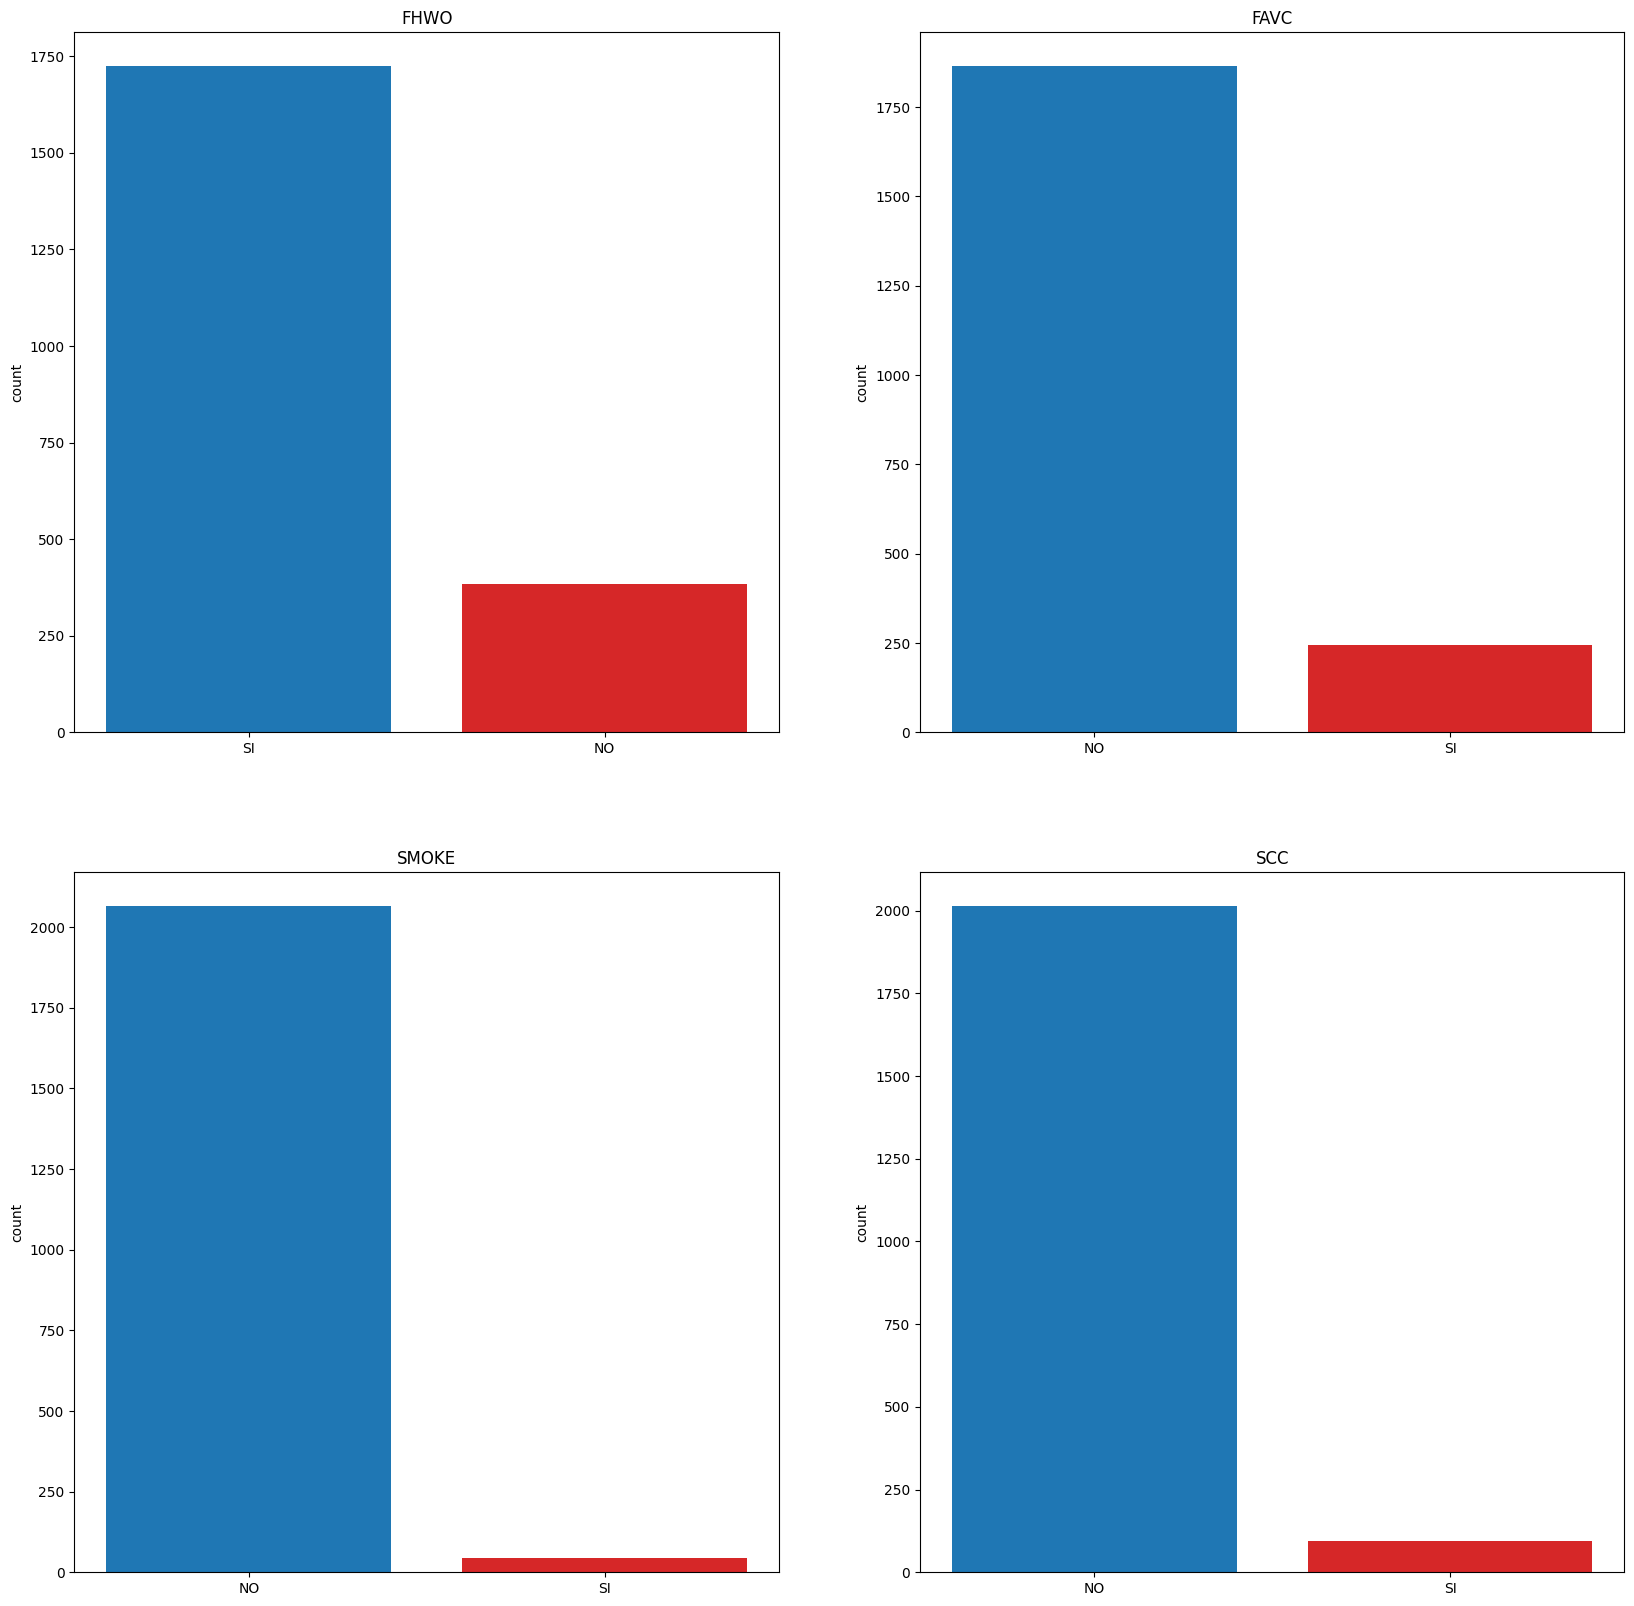

In [116]:
color = ['tab:blue', 'tab:red']
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('FHWO')
plt.bar(obesity_row_data['FHWO'].replace({True: "SI", False: "NO"}).unique(),
        obesity_row_data['FHWO'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 2)
plt.title('FAVC')
plt.bar(obesity_row_data['FAVC'].replace({True: "SI", False: "NO"}).unique(),
        obesity_row_data['FAVC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 3)
plt.title('SMOKE')
plt.bar(obesity_row_data['SMOKE'].replace({True: "SI", False: "NO"}).unique(),
        obesity_row_data['SMOKE'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 4)
plt.title('SCC')
plt.bar(obesity_row_data['SCC'].replace({True: "SI", False: "NO"}).unique(),
        obesity_row_data['SCC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.show()

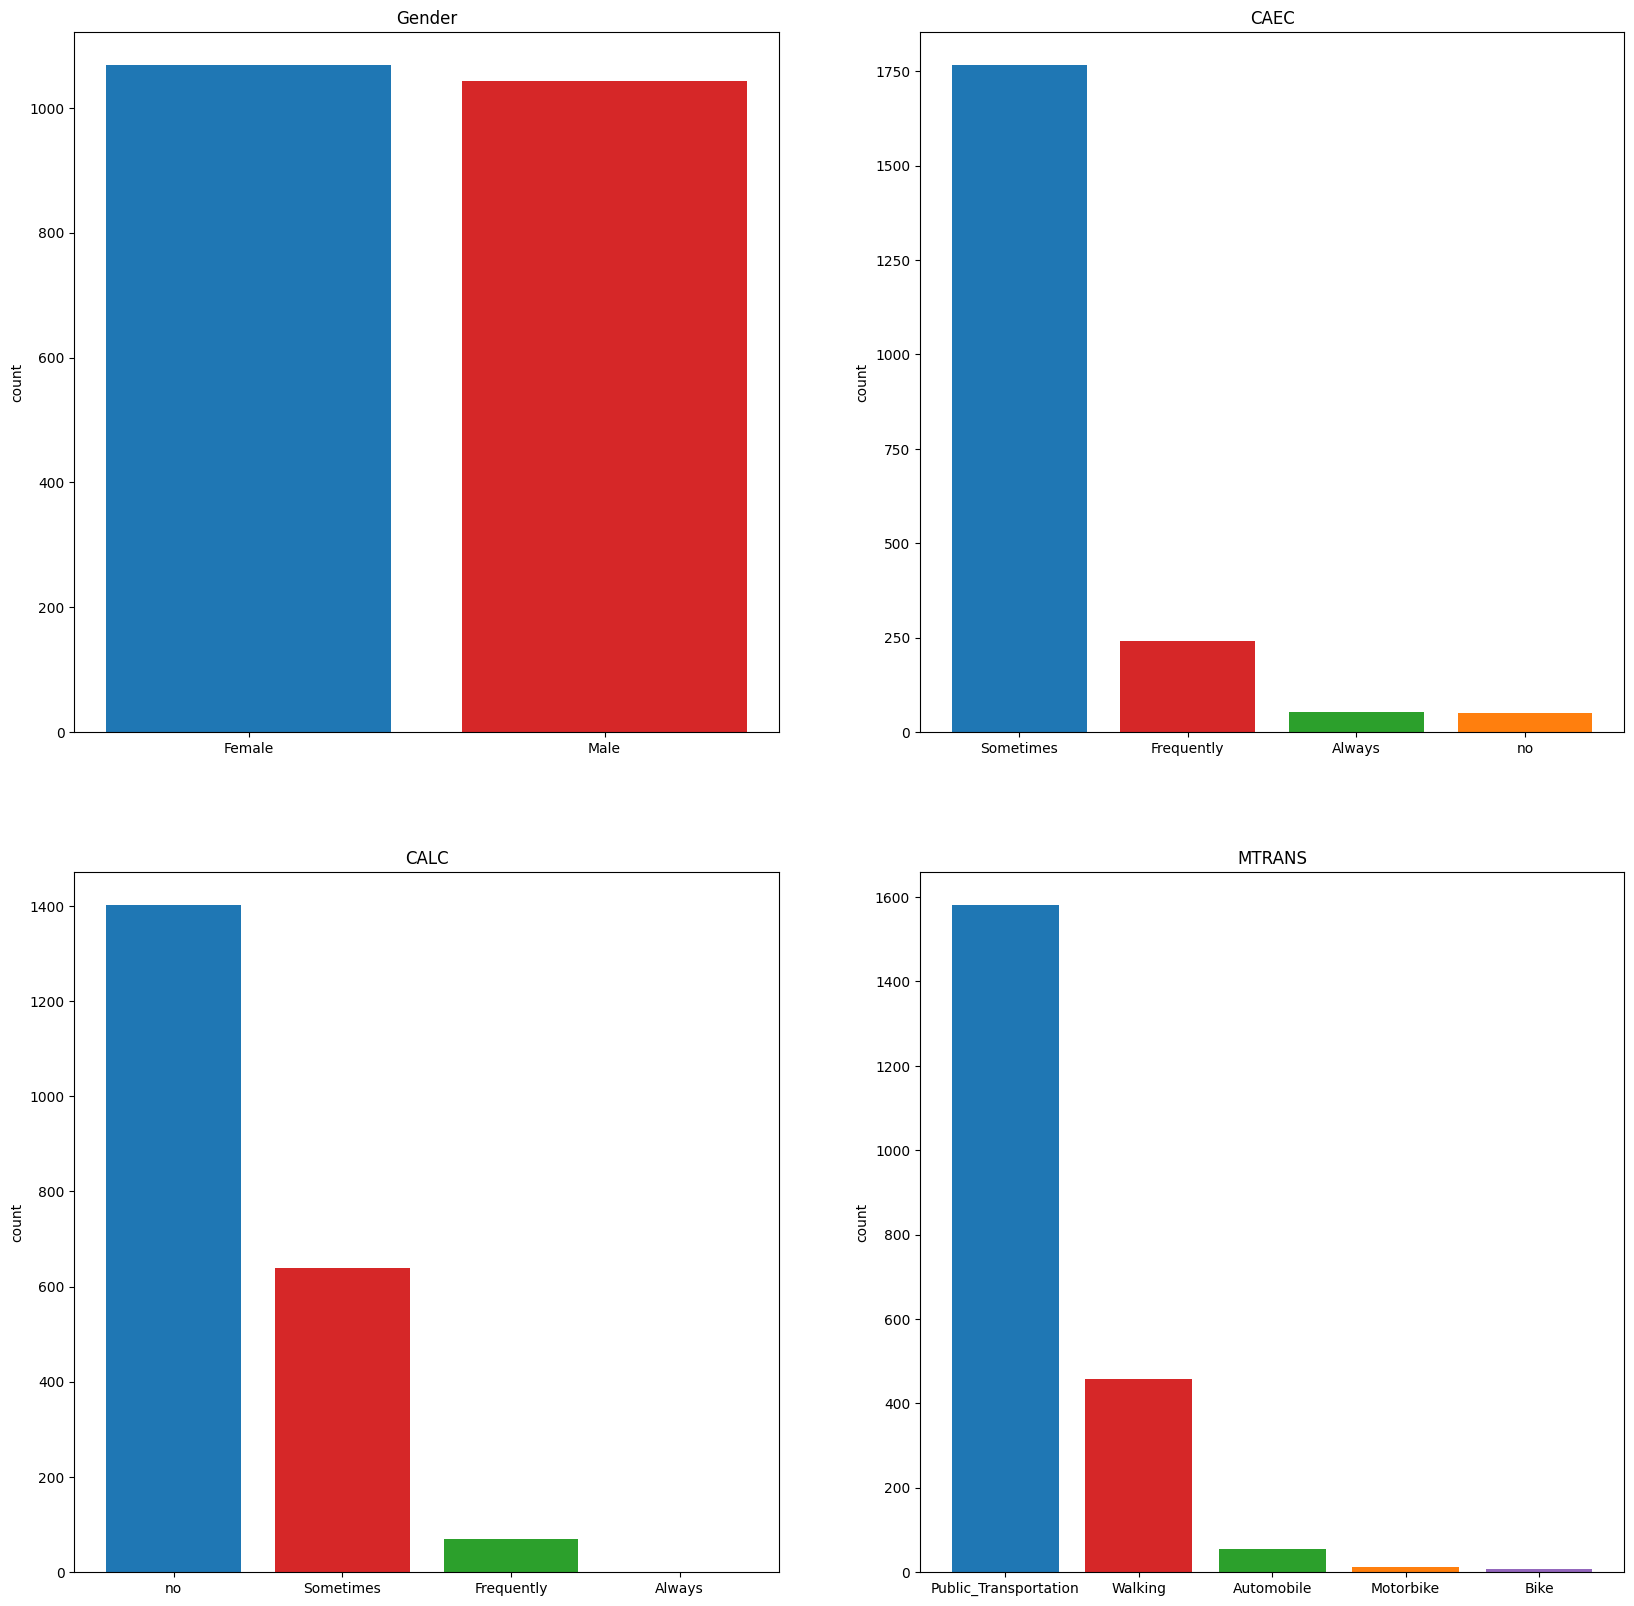

In [115]:
color= ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Gender')
plt.bar(obesity_row_data['Gender'].unique(),
        obesity_row_data['Gender'].value_counts(),
        color=color)
plt.ylabel('count')



plt.subplot(2, 2, 2)
plt.title('CAEC')
plt.bar(obesity_row_data['CAEC'].unique(),
        obesity_row_data['CAEC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 3)
plt.title('CALC')
plt.bar(obesity_row_data['CALC'].unique(),
        obesity_row_data['CALC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 4)
plt.title('MTRANS')
plt.bar(obesity_row_data['MTRANS'].unique(),
        obesity_row_data['MTRANS'].value_counts(),
        color=color)
plt.ylabel('count')

plt.show()

In [94]:
obesity_row_data['CALC'].value_counts()

CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64